# Phase digram on $(\eta_{AA}, \eta_{BB})$ plane

Here, $\omega_{SS'}$ reads

$$
\omega_{SS'} = \frac{\phi_S}{\bar{v}_S} \left.\frac{\partial v_{S}}{\partial \rho_{S'}}\right|_{\{\phi_S\}},
$$
where $\bar{v}_S = v_S(\phi_A, \phi_B)$ and $v_S$ is determined by
$$
v_S(\rho_A(\mathbf{r}), \rho_B(\mathbf{r})) = v_{S,0} \tilde{v}_{SA}(\rho_A(\mathbf{r}))\tilde{v}_{SB}(\rho_B(\mathbf{r})),
$$
with
$$
\begin{aligned}
\tilde{v}_{SA}(\rho_A(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SA}}{\kappa}\frac{\rho_A(\mathbf{r})-\bar{\rho}_A}{\rho_0}
	\right),\\
\tilde{v}_{SB}(\rho_B(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SB}}{\kappa}\frac{\rho_B(\mathbf{r})-\bar{\rho}_B}{\rho_0}
	\right).
\end{aligned}
$$
Then
$$\omega_{SS'}=\frac{\phi_S}{\tilde{v}_{SS'}(\phi_{S'})} \tilde{v}_{SS'}'(\phi_{S'}),$$
where
$$
\begin{aligned}
\tilde{v}_{SA}'(\rho_A)&=\partial_{\rho_A} \tilde{v}_{SA} = \frac{\eta_{SA}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SA}}{\kappa}\frac{\rho_A-\bar{\rho}_A}{\rho_0}\right)\right] = \frac{\eta_{SA}}{\rho_0} \left[
    1 - \left(\frac{\tilde{v}_{SA}-1}{\kappa}\right)^2
\right],\\
\tilde{v}_{SB}'(\rho_B)&=\partial_{\rho_B} \tilde{v}_{SB} = \frac{\eta_{SB}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SB}}{\kappa}\frac{\rho_B-\bar{\rho}_B}{\rho_0}\right)\right] = \frac{\eta_{SB}}{\rho_0} \left[
    1 - \left(\frac{\tilde{v}_{SB}-1}{\kappa}\right)^2
\right].
\end{aligned}
$$

## Special case with $\phi_A=\bar{\rho}_A$ and $\phi_B=\bar{\rho}_B$

In this case, $\tilde{v}_{SS'}(\phi_{S'})=1$, $\tilde{v}_{SS'}'(\phi_{S'})=\frac{\eta_{SS'}}{\rho_0}$, then
$$
\begin{aligned}
\omega_{SS'} &= \frac{\phi_S}{\rho_0} \eta_{SS'}, \\
\bar{v}_S &= v_{S,0}.
\end{aligned}
$$

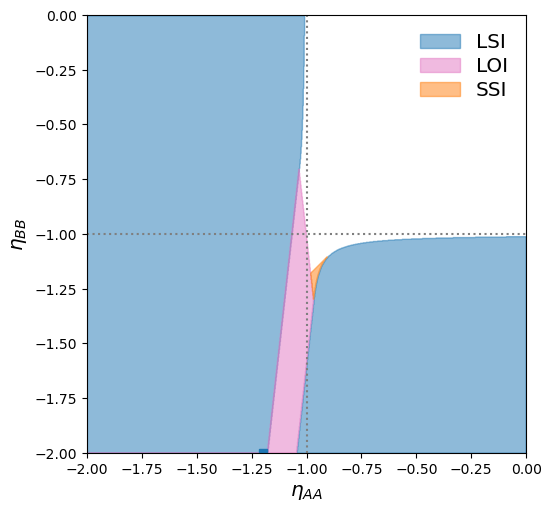

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from general_PD import find_long_instabi, find_short_instabi, find_contours
import matplotlib.patches as mpatches

def get_PD_eta_data(etaAB, etaBA, Dr_A, Dr_B, vA0, vB0, phiA=1, phiB=1,
                    extent=[-4, 4, -4, 4], qmin=1e-5, qmax=1, Nq=200, resolution=1000, overwrite=False, ll=3./20, simple_gamma=False):
    folder = "data/PD_eta/"
    fout = "%se%g_%g_D%g_%g_v%g_%g_p%g_%g_qm%g_r%g.npz" % (
        folder, etaAB, etaBA, Dr_A, Dr_B, vA0, vB0, phiA, phiB, qmax, resolution
    )
    if not overwrite and os.path.exists(fout):
        with np.load(fout, "rb") as data:
            return data["extent"], data["state"], data["q_range"], data["q0_a4"], data["q0_D3"]
    else:
        nrows, ncols = resolution, resolution
        etaAA, etaBB = np.meshgrid(
            np.linspace(extent[0], extent[1], ncols), np.linspace(extent[2], extent[3], nrows))
        wAA = phiA * etaAA
        wBB = phiB * etaBB
        wAB = phiA * etaAB
        wBA = phiB * etaBA
        w1 = 1 + wAA
        w2 = 1 + wBB
        wc = wAB * wBA
        sigma_D = Dr_A / Dr_B
        sigma_v = vA0 / vB0
        Pe = vB0 / Dr_B

        mask_LS, mask_LOI, mask_LSI = find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc, q0=qmin, ll=ll, simple_gamma=simple_gamma)
        q0_a4, q0_Delta3 = np.zeros((2, nrows, ncols))
        for row in range(nrows):
            for col in range(ncols):
                if mask_LS[row, col]:
                    q0_a4[row, col], q0_Delta3[row, col] = find_short_instabi(
                        sigma_D, sigma_v, Pe, w1[row, col], w2[row, col], wc, qmin=qmin, qmax=qmax, Nq=Nq, ll=ll, simple_gamma=simple_gamma)
        state = np.zeros((nrows, ncols), dtype=np.byte)
        state[mask_LSI] = 1
        state[mask_LOI] = 2
        state[q0_a4 > 0] = 3
        state[q0_Delta3 > 0] = 4
        q_range = np.array([qmin, qmax, Nq])
        np.savez_compressed(fout, extent=extent, state=state, q_range=q_range, q0_a4=q0_a4, q0_D3=q0_Delta3)
        return extent, state, q_range, q0_a4, q0_Delta3

def plot_PD_eta(state, extent, xlim=None, ylim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    contours = find_contours(state)
    for contour in contours["LWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if contour[:, 0].max() == nrows - 1:
            ax.fill_betweenx(y, extent[0], x, color="tab:blue", alpha=0.5)
        elif contour[:, 1].max() == ncols - 1:
            ax.fill_between(x, extent[2], y, color="tab:blue", alpha=0.5)
        # ax.plot(x, y, c="tab:blue", lw=1)
        # ax.fill(x, y, c="tab:blue", alpha=0.5)

    for contour in contours["LWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        # ax.plot(x, y, c="tab:pink", lw=1)
        # ax.fill(x, y, c="tab:pink", alpha=0.5)
        x_new = np.zeros(x.size+1)
        y_new = np.zeros(y.size+1)
        x_new[:x.size] = x
        y_new[:y.size] = y
        x_new[-1] = extent[0]
        y_new[-1] = extent[2]
        ax.fill(x_new, y_new, c="tab:pink", alpha=0.5)


    for contour in contours["SWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill(x, y, c="tab:orange", alpha=0.5)


    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill(x, y, c="tab:green", alpha=0.5)

    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.axhline(-1, linestyle=":", c="tab:grey")
    ax.axvline(-1, linestyle=":", c="tab:grey")

    if flag_show:
        plt.show()
        plt.close()
    

etaAB = -0.1
etaBA = 0.1
Dr_A = 6
Dr_B = 6
vA0 = 3
vB0 = 1

extent = [-2, 0, -2, 0]
extent, state, q_range, q0_a4, q0_Delta3 = get_PD_eta_data(etaAB, etaBA, Dr_A, Dr_B, vA0, vB0, qmax=2.5, resolution=1000, extent=extent, overwrite=False)
fig, ax = plt.subplots(1, 1, figsize=(5.4, 5), constrained_layout=True)
plot_PD_eta(state, extent, ax=ax)
# ax.plot(-0.6, -1.4, "o")
# ax.plot(0, -1.4, "o")
# ax.plot(0.6, -1.4, "o")
# ax.plot(1.0, -1.4, "o")
# ax.plot(1.4, -1.4, "o")

# ax.plot(-1.2, -2, "s")
# ax.plot(-0.2, -2.2, "*")

patches = [mpatches.Patch(color='tab:blue', label='LSI', alpha=0.5),
           mpatches.Patch(color='tab:pink', label='LOI',alpha=0.5),
           mpatches.Patch(color='tab:orange', label='SSI', alpha=0.5),
        #    mpatches.Patch(color='tab:green', label='Short-wave Oscillatory\nInstability (SOI)', alpha=0.25),
        ]
legend = ax.legend(handles=patches, loc="upper right", fontsize="x-large", frameon=False, labelspacing=0.25)

ax.set_xlim(-2, 0)
ax.set_ylim(-2, 0)
ax.set_xlabel(r"$\eta_{AA}$", fontsize="x-large")
ax.set_ylabel(r"$\eta_{BB}$", fontsize="x-large")
plt.show()
plt.close()

# etaAB = 0.25
# etaBA = -0.25
# Dr_A = 6
# Dr_B = Dr_A
# vA0 = 3
# vB0 = 1
# extent, state, q_range, q0_a4, q0_Delta3 = get_PD_eta_data(etaAB, etaBA, Dr_A, Dr_B, vA0, vB0, qmax=2.5)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
# plot_PD_eta(state, extent, ax=ax1)
# ax1.plot(-0.8, -1.3, "*")

# # ax1.plot(-1.3, -2, "*")
# # ax1.plot(-1.2, -2, "*")
# # ax1.plot(-1.1, -2, "*")
# # ax1.plot(-1.0, -2, "*")
# # ax1.plot(-1.0, -1, "*")
# ax1.plot(-1.4, -3, "p")
# ax1.plot(-1.3, -2, "p")
# ax1.plot(-1.2, -2, "p")

# # ax1.plot(-1.1, -3, "p")


# # ax1.plot(-0.5, -2.8, "p")
# # ax1.plot(-0.6, -2.8, "p")
# # ax1.plot(-0.7, -2.8, "p")
# # ax1.plot(-0.8, -2,8, "p")
# # ax1.plot(-0.6, -3.4, "p")

# # ax1.plot(-0.5, -2.5, "D")
# # ax1.plot(-0.6, -2.6, ">")
# # ax1.plot(-0.8, -2.8, "<")
# # ax1.plot(-0.5, -2.8, "D")



# ax2.imshow(q0_a4, extent=extent, origin="lower")
# ax2.set_xlim(-2, 0)
# ax2.set_ylim(-3, -1)
# plt.show()
# plt.close()

In [2]:
def get_tilde_w1_w2(wAA, wBB, wc, sigma):
    tilde_w1 = 1 / np.sqrt(sigma * np.abs(wc)) * (wAA + 1)
    tilde_w2 = np.sqrt(sigma / np.abs(wc)) * (wBB + 1)
    return tilde_w1, tilde_w2


def get_wAA_wBB(tilde_w1, tilde_w2, wc, sigma):
    wAA = tilde_w1 * np.sqrt(sigma * np.abs(wc)) - 1
    wBB = tilde_w2 / np.sqrt(sigma / np.abs(wc)) - 1
    return wAA, wBB

sigma = 1/9
chi_c = -0.25 ** 2

eta_AA, eta_BB = -0.9, -1.45
w1, w2 = get_tilde_w1_w2(eta_AA, eta_BB, chi_c, sigma)
print("w1=%g,w2=%g" % (w1, w2))

chi_c_new = -0.25
eta_AA_new, eta_BB_new = get_wAA_wBB(w1, w2, chi_c_new, sigma)
print(eta_AA_new, eta_BB_new)

# chi_c_new = -0.25**2
# eta_AA_new, eta_BB_new = get_wAA_wBB(w1, w2, chi_c_new, sigma)
# print(eta_AA_new, eta_BB_new)

# sigma = 1 
# chi_c_new = -1
# eta_AA = -0.6
# eta_BB = -1.4

# w1, w2 = get_tilde_w1_w2(eta_AA, eta_BB, chi_c_new, sigma)
# print(w1, w2)

eta_AA = -2
eta_BB = -10
w1, w2 = get_tilde_w1_w2(eta_AA, eta_BB, chi_c, sigma)
print("w1=%g,w2=%g" % (w1, w2))



w1=1.2,w2=-0.6
-0.8 -1.9
w1=-12,w2=-12
